In [3]:
import zipfile

with zipfile.ZipFile("/content/dataset_3classes.zip", 'r') as zip_ref:
    zip_ref.extractall("unzipped_folder")  # Change folder name if needed


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

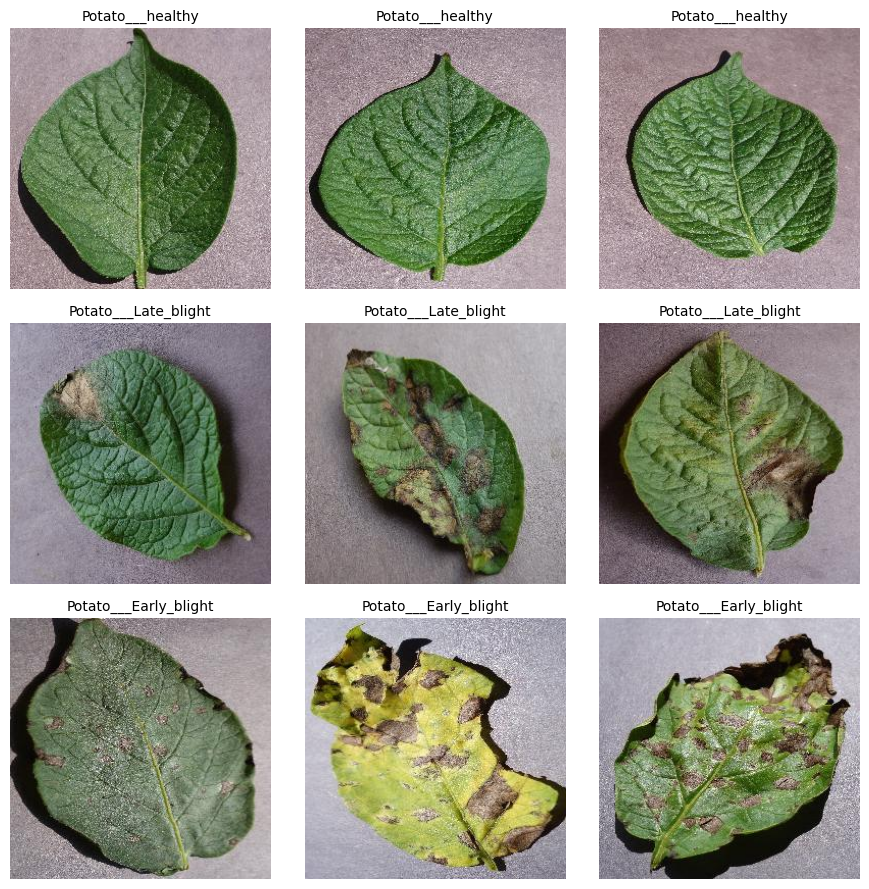

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Set your dataset path
dataset_path = "/content/unzipped_folder/dataset_3classes"

# Get list of class folders (subdirectories)
class_names = os.listdir(dataset_path)

# Show 3 images from each class
images_per_class = 3

plt.figure(figsize=(images_per_class * 3, images_per_class* 3))

for row, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_dir)

    # Randomly pick images from each class
    selected_images = random.sample(image_files, images_per_class)

    for col, image_name in enumerate(selected_images):
        image_path = os.path.join(class_dir, image_name)
        image = Image.open(image_path)

        # Plotting
        plt.subplot(len(class_names), images_per_class, row * images_per_class + col + 1)
        plt.imshow(image)
        plt.title(class_name, fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Names of each plant class
class_names

['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']

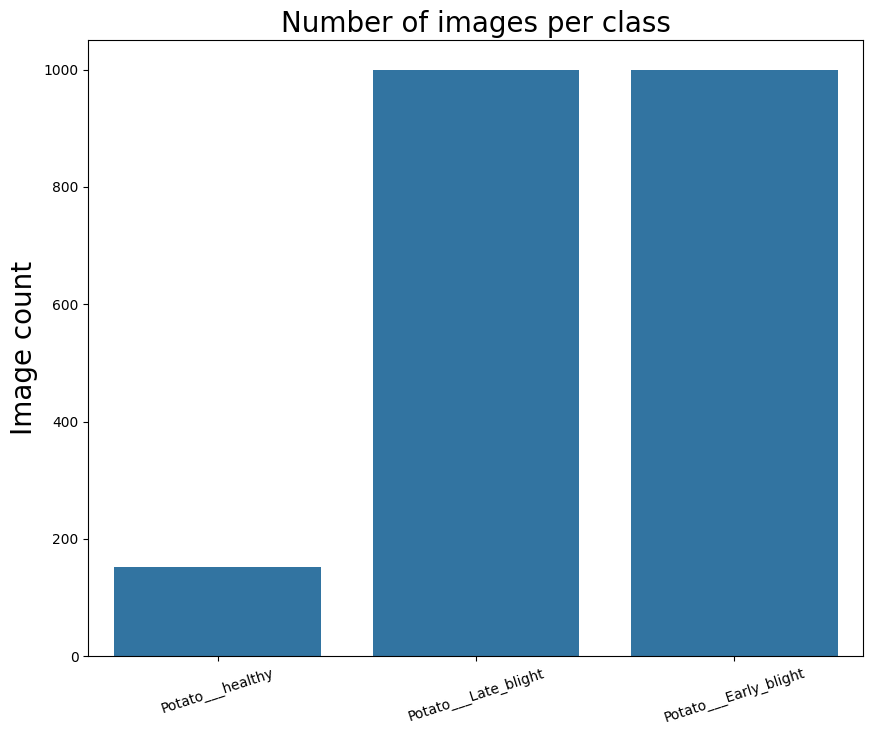

In [7]:
# Images count for ach class and plotting images count

import seaborn as sns
import pandas as pd

class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 8))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Number of images per class",fontsize=20)
plt.ylabel("Image count",fontsize=20)
plt.xticks(rotation=18)
plt.show()

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set original and new dataset paths
original_dataset_dir = "/content/unzipped_folder/dataset_3classes"
base_dir = "/content/dataset-3classes"

# Define split ratios
test_ratio = 0.15
val_ratio = 0.15

# Create directories
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(original_dataset_dir):
        split_path = os.path.join(base_dir, split, class_name)
        os.makedirs(split_path, exist_ok=True)

# Go through each class folder
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    images = os.listdir(class_dir)
    images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]  # filter image files

    # Split into train+val and test
    train_val_imgs, test_imgs = train_test_split(images, test_size=test_ratio, random_state=42)

    # Split train_val into train and val
    train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=val_ratio / (1 - test_ratio), random_state=42)

    # Copy files
    for img_name in train_imgs:
        src = os.path.join(class_dir, img_name)
        dst = os.path.join(base_dir, 'train', class_name, img_name)
        shutil.copy(src, dst)

    for img_name in val_imgs:
        src = os.path.join(class_dir, img_name)
        dst = os.path.join(base_dir, 'val', class_name, img_name)
        shutil.copy(src, dst)

    for img_name in test_imgs:
        src = os.path.join(class_dir, img_name)
        dst = os.path.join(base_dir, 'test', class_name, img_name)
        shutil.copy(src, dst)

print("Dataset successfully split into train, val, and test folders.")

Dataset successfully split into train, val, and test folders.


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

train_dir = '/content/dataset-3classes/train'
val_dir = '/content/dataset-3classes/val'
test_dir = '/content/dataset-3classes/test'

# Define image size and batch size
image_size = (224, 224) # Example size, adjust as needed
batch_size = 32 # Example batch size, adjust as needed

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)#,preprocessing_function=preprocess_input) # Initialize train_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Usually no shuffling for validation data
)

test_datagen = ImageDataGenerator(rescale=1./255) # Initialize test_datagen

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Usually no shuffling for test data
)

Found 900 images belonging to 3 classes.
Found 323 images belonging to 3 classes.
Found 323 images belonging to 3 classes.


In [25]:
import os

# Set the path to your dataset
dataset_path = "/content/dataset-3classes/train"  # or /content/dataset_split/train for split data

# Count images in each class
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_count = len([
            img for img in os.listdir(class_path)
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        print(f"Class '{class_name}': {image_count} images")

Class 'Potato___healthy': 300 images
Class 'Potato___Late_blight': 300 images
Class 'Potato___Early_blight': 300 images


In [26]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm

# CONFIG
train_dir = '/content/dataset-3classes/train'  # Change this to your actual train folder path
image_extensions = ('.jpg', '.jpeg', '.png')  # Image file types to consider

# Define augmentation strategy
augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# 1. Count images in each class
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(image_extensions)]
        class_counts[class_name] = len(image_files)

# 2. Find the target count (maximum class size)
target_count = max(class_counts.values())
print(f"Target image count per class: {target_count}")

# 3. Augment minority classes
for class_name, current_count in class_counts.items():
    if current_count >= target_count:
        print(f"Skipping '{class_name}' (already has {current_count} images)")
        continue

    print(f"\n Augmenting class '{class_name}' ({current_count} ➝ {target_count})")

    class_path = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_extensions)]

    n_to_generate = target_count - current_count
    generated = 0
    idx = 0

    with tqdm(total=n_to_generate, desc=f"Augmenting {class_name}") as pbar:
        while generated < n_to_generate:
            img_name = images[idx % len(images)]
            img_path = os.path.join(class_path, img_name)

            try:
                img = load_img(img_path)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)

                for batch in augmentor.flow(
                    x,
                    batch_size=1,
                    save_to_dir=class_path,
                    save_prefix='aug',
                    save_format='jpg'
                ):
                    generated += 1
                    pbar.update(1)
                    break  # Generate only one image per loop

            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

            idx += 1

print("\n All minority classes have been balanced via augmentation.")



Target image count per class: 300
Skipping 'Potato___healthy' (already has 300 images)
Skipping 'Potato___Late_blight' (already has 300 images)
Skipping 'Potato___Early_blight' (already has 300 images)

 All minority classes have been balanced via augmentation.


In [18]:
import os
import random

# Set your training dataset path
train_dir = '/content/dataset-3classes/train'  # e.g., 'dataset/train'

# How many images to delete per class
num_to_delete = 400

# Loop through each class folder
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        if len(images) > num_to_delete:
            images_to_delete = random.sample(images, num_to_delete)

            for img_name in images_to_delete:
                img_path = os.path.join(class_path, img_name)
                os.remove(img_path)

            print(f"Deleted {num_to_delete} images from {class_name}")
        else:
            print(f"Not enough images in {class_name} to delete {num_to_delete}")


Deleted 400 images from Potato___healthy
Deleted 400 images from Potato___Late_blight
Deleted 400 images from Potato___Early_blight


In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,331 (2.61 MB)

 Trainable params: 683,331 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
history=model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.3947 - loss: 1.2938 - val_accuracy: 0.4613 - val_loss: 1.0666
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6091 - loss: 0.8961 - val_accuracy: 0.6037 - val_loss: 0.6953
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7923 - loss: 0.4796 - val_accuracy: 0.8173 - val_loss: 0.4662
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8647 - loss: 0.3286 - val_accuracy: 0.8700 - val_loss: 0.3530
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8820 - loss: 0.2615 - val_accuracy: 0.8421 - val_loss: 0.3575
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9202 - loss: 0.2055 - val_accuracy: 0.8947 - val_loss: 0.2738
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9307 - loss: 0.1632 - val_accuracy: 0.9040 - val_loss: 0.2525
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9381 - loss: 0.1566 - val_accuracy: 0.8854 

In [70]:
score=model.evaluate(test_generator)
score

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9379 - loss: 0.2053


[0.27450796961784363, 0.9195046424865723]

In [71]:
# Get a batch of images and labels from the test dataset
for images, labels in test_generator:
    # Make predictions
    predictions = model.predict(images)

    # Get the class names from the generator's class_indices attribute
    class_names = list(test_generator.class_indices.keys())

    print("Predictions for the first few images:\n")
    for i in range(min(30, len(images))):
        predicted_class_index = tf.argmax(predictions[i]).numpy()
        actual_class_index = tf.argmax(labels[i]).numpy()

        predicted_class_name = class_names[predicted_class_index]
        actual_class_name = class_names[actual_class_index]

        print(f"Image {i+1}: Predicted = {predicted_class_name}, Actual = {actual_class_name}")

    break # Only process one batch to avoid iterating through the entire test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Predictions for the first few images:

Image 1: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 2: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 3: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 4: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 5: Predicted = Potato___healthy, Actual = Potato___Late_blight
Image 6: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 7: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 8: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 9: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 10: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 11: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 12: Predicted = Potato___Late_blight, Actual = Potato___Late_blight
Image 13: Predicted = Potato___Late_blight, Act

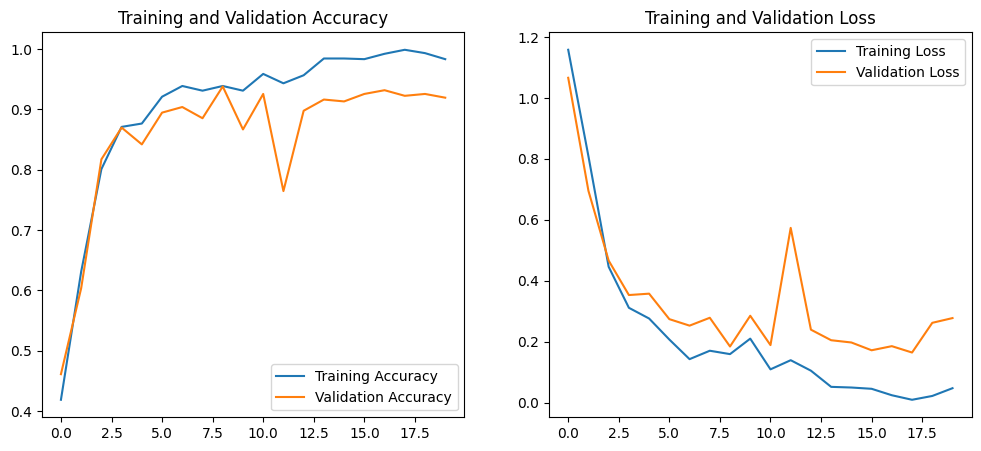

In [72]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Accuracy: 0.9195

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.94      0.96      0.95       150
 Potato___Late_blight       0.96      0.87      0.91       150
     Potato___healthy       0.70      1.00      0.82        23

             accuracy                           0.92       323
            macro avg       0.86      0.94      0.89       323
         weighted avg       0.93      0.92      0.92       323



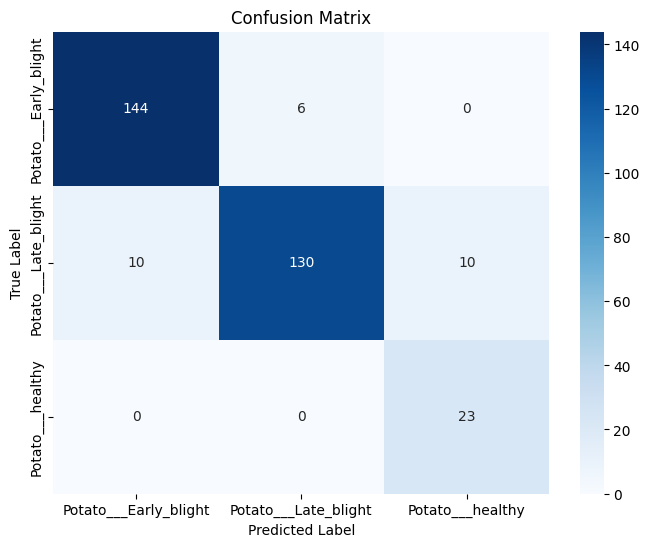

In [73]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names from generator
class_names = list(test_generator.class_indices.keys())

# Store all true and predicted labels
true_labels = []
predicted_labels = []

# Loop through all batches in the test generator
for images, labels in test_generator:
    predictions = model.predict(images)
    predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
    true_labels.extend(tf.argmax(labels, axis=1).numpy())

    # Stop when we've processed the full dataset
    if len(true_labels) >= test_generator.samples:
        break

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# --- Accuracy ---
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# --- Precision, Recall, F1-score ---
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("potato_disease_model.keras")

In [ ]:
from google.colab import files
files.download("potato_disease_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task
Explain the error in the provided code, fix it, and incorporate the changes. If fixing is not possible, diagnose the error.

## Install keras tuner

### Subtask:
Install the Keras Tuner library.


**Reasoning**:
The subtask requires installing the `keras-tuner` library. The most straightforward way to do this is by using pip.



## Define the tunable model

### Subtask:
Define the tunable model


**Reasoning**:
Define a function that creates the CNN model with tunable hyperparameters for use with Keras Tuner.



## Initialize and run the tuner

### Subtask:
Set up and run the Keras Tuner to search for the best hyperparameters using the training data.


**Reasoning**:
Import the necessary tuner and set up the tuner object for hyperparameter search.



**Reasoning**:
Run the hyperparameter search using the tuner's search method with the training and validation data generators.

